In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error
from datetime import datetime
plt.style.use('fivethirtyeight')

In [28]:
# Fetch Bitcoin historical data from Yahoo Finance
ticker = "BTC-USD"
end=datetime.now() # current date
start = datetime(end.year-15,end.month,end.day) # 15 years before the current date 
data = yf.download(ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [29]:
data

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-03-04,87222.195312,88911.273438,81529.242188,86064.070312,68095241474
2025-03-05,90623.562500,90998.242188,86379.773438,87222.953125,50498988027


In [30]:
data = data[['Close']]
data = data.dropna()

In [31]:
data

Price,Close
Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-03-04,87222.195312
2025-03-05,90623.562500


In [32]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [33]:
# Split the data into training and testing sets
time_step = 60
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [34]:
# Reshape data for LSTM/GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [35]:
# Function to build models
def build_model(model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(50, return_sequences=False))
    
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [36]:
# Train and evaluate LSTM model
lstm_model = build_model('LSTM')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

C:\Users\Raj Desai\Desktop\bitcoin price prediction using gru and lstm\jupyter_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0093 - val_loss: 9.7175e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 6.1109e-04 - val_loss: 0.0015
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 5.3867e-04 - val_loss: 0.0019
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 4.9521e-04 - val_loss: 8.7467e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 4.5995e-04 - val_loss: 0.0039
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 4.0899e-04 - val_loss: 0.0020
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 4.0253e-04 - val_loss: 6.4199e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 4.6123e-04 - val_loss: 7.2258e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 3.7855e-04 - val_loss: 0.0022
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 3.7721e-04 - val_loss: 0.0013


In [37]:
# Train and evaluate GRU model
gru_model = build_model('GRU')
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 5.1141e-04 - val_loss: 4.7956e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.6988e-04 - val_loss: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 3.7612e-04 - val_loss: 5.5596e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 4.9472e-04 - val_loss: 3.8099e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 3.8063e-04 - val_loss: 0.0015
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 3.9149e-04 - val_loss: 6.7694e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 2.9474e-04 - val_loss: 0.0028
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 3.3956e-04 - val_loss: 4.0596e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 3.0613e-04 - val_loss: 3.2597e-04


In [38]:
# Function to predict future prices
def predict_future(model, last_data, future_days=30):
    future_predictions = []
    input_seq = last_data[-time_step:].reshape(1, time_step, 1)
    
    for _ in range(future_days):
        pred = model.predict(input_seq)[0][0]
        future_predictions.append(pred)
        new_input = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
        input_seq = new_input
    
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [39]:
# Predict future prices
future_days = 30
y_future_lstm = predict_future(lstm_model, data_scaled, future_days)
y_future_gru = predict_future(gru_model, data_scaled, future_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━

In [40]:
# Predictions for test set
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step  


In [41]:
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [42]:
# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))

print(f"LSTM RMSE: {rmse_lstm}")
print(f"GRU RMSE: {rmse_gru}")

LSTM RMSE: 3867.279999957228
GRU RMSE: 1913.2151197041676


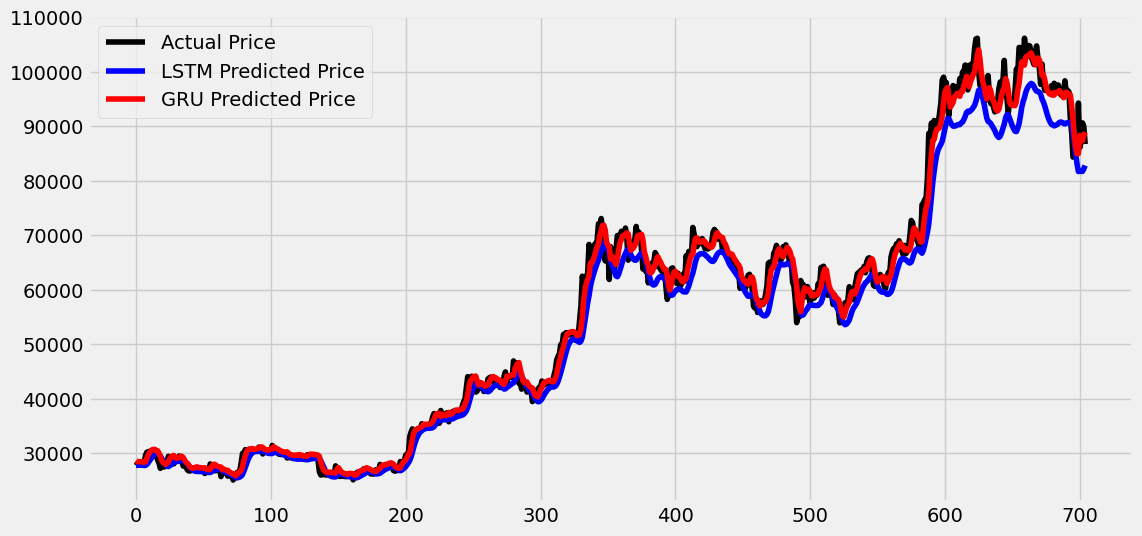

In [43]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Price', color='black')
plt.plot(y_pred_lstm, label='LSTM Predicted Price', color='blue')
plt.plot(y_pred_gru, label='GRU Predicted Price', color='red')
plt.legend()
plt.show()

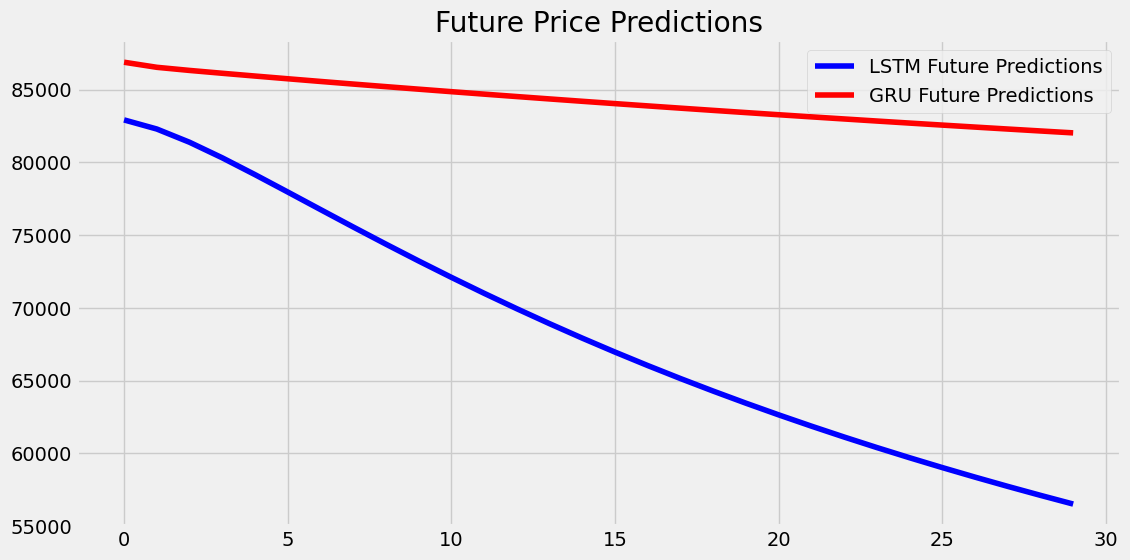

In [44]:
# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(range(len(y_future_lstm)), y_future_lstm, label='LSTM Future Predictions', color='blue')
plt.plot(range(len(y_future_gru)), y_future_gru, label='GRU Future Predictions', color='red')
plt.legend()
plt.title("Future Price Predictions")
plt.show()